#Librerias

In [1]:
import pandas as pd
import os

# Librerías de manipulación de datos
import pandas as pd
import numpy as np

# Opciones de Pandas
pd.set_option('display.max_columns', None)

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import plotly.express as px

# Librerías para estadística y pruebas
import scipy.stats as stats
from scipy.stats import gaussian_kde, kstest, norm, shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Librerías de machine learning y preprocesamiento
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Librerías para métricas de modelos
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
import math

#Carga de datos

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [3]:
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.30GB/s]


In [4]:
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia

Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [43]:
df_train=pd.read_csv('train.csv')

#Análisis exploratorio

In [45]:
df_train.head(3)

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264


In [46]:
def visual_check(df):

    print('Shape:\n',df.shape,'\n')

    print('Data Types:\n', df.dtypes,'\n\n')

    df_colum_duplicated=df.columns.duplicated()
    print("Columnas duplicadas:\n",df_colum_duplicated,'\n\n')

    df_fil_duplicated=df.duplicated()
    print("Filas duplicadas:\n",df_fil_duplicated,'\n\n')

    df_colum_faltantes=df.columns[df.isnull().any()]
    print("Datos faltantes por columnas:\n",df_colum_faltantes,'\n\n')

    display(df.describe().T)

visual_check(df_train)

Shape:
 (692500, 21) 

Data Types:
 ID                               int64
PERIODO_ACADEMICO                int64
E_PRGM_ACADEMICO                object
E_PRGM_DEPARTAMENTO             object
E_VALORMATRICULAUNIVERSIDAD     object
E_HORASSEMANATRABAJA            object
F_ESTRATOVIVIENDA               object
F_TIENEINTERNET                 object
F_EDUCACIONPADRE                object
F_TIENELAVADORA                 object
F_TIENEAUTOMOVIL                object
E_PRIVADO_LIBERTAD              object
E_PAGOMATRICULAPROPIO           object
F_TIENECOMPUTADOR               object
F_TIENEINTERNET.1               object
F_EDUCACIONMADRE                object
RENDIMIENTO_GLOBAL              object
INDICADOR_1                    float64
INDICADOR_2                    float64
INDICADOR_3                    float64
INDICADOR_4                    float64
dtype: object 


Columnas duplicadas:
 [False False False False False False False False False False False False
 False False False False False Fa

,count,mean,std,min,25%,50%,75%,max
ID,692500.0,494606.130576,285585.209455,1.0,247324.750,494564.500,741782.500,989286.000
PERIODO_ACADEMICO,692500.0,20198.366679,10.535037,20183.0,20195.000,20195.000,20203.000,20213.000
INDICADOR_1,692500.0,0.268629,0.122130,0.0,0.203,0.240,0.314,0.657
INDICADOR_2,692500.0,0.259996,0.093480,0.0,0.212,0.271,0.309,0.487
INDICADOR_3,692500.0,0.262087,0.058862,0.0,0.254,0.276,0.293,0.320
INDICADOR_4,692500.0,0.262903,0.067944,0.0,0.255,0.285,0.303,0.332


*Datos faltantes*

In [47]:
# Seleccionar solo las columnas de interés
cols = [
    'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA',
       'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE',
       'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PAGOMATRICULAPROPIO',
       'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE'
]

# Crear dataset de faltantes
faltantes_df = pd.DataFrame({
    "Columna": cols,
    "Faltantes": df_train[cols].isnull().sum().values,
    "Porcentaje (%)": (df_train[cols].isnull().mean().values * 100).round(2)
})

faltantes_df

,Columna,Faltantes,Porcentaje (%)
0,E_VALORMATRICULAUNIVERSIDAD,6287,0.91
1,E_HORASSEMANATRABAJA,30857,4.46
2,F_ESTRATOVIVIENDA,32137,4.64
3,F_TIENEINTERNET,26629,3.85
4,F_EDUCACIONPADRE,23178,3.35
5,F_TIENELAVADORA,39773,5.74
6,F_TIENEAUTOMOVIL,43623,6.30
7,E_PAGOMATRICULAPROPIO,6498,0.94
8,F_TIENECOMPUTADOR,38103,5.50
9,F_TIENEINTERNET.1,26629,3.85


In [48]:
df_train['ID']=df_train['ID'].astype('object')
df_train['PERIODO_ACADEMICO']=df_train['PERIODO_ACADEMICO'].astype('object')

In [49]:
df_train.fillna('otro',inplace=True)

In [50]:
df_train.drop(columns=['F_TIENEINTERNET.1'], inplace=True)

El dataset de entrenamiento está conformado por 692500 filas y 21 columnas (variables). El dataset no tiene columnas repetidas con el mismo nombre pero si tiene repetida la columna "F_TIENEINTERNET" como "F_TIENEINTERNET.1" esto debido a que ambas columnas tienen la misma cantidad de datos con SI y NO y tambien la misma cantidad de faltantes. No tiene filas duplicadas pero si tiene datos faltantes; entre las columnas con mayor proporción de faltantes se encuentran 'F_TIENEAUTOMOVIL', 'F_TIENELAVADORA' y 'F_TIENE COMPUTADOR' que representan más del 50% de los faltantes otras como 'E_VALORMATRICULAUNIVERSIDAD' y 'E_PAGOMATRICULAPROPIO' no representan ni el 1% de los faltantes. Se modificaron los tipos de datos para 'ID' y para 'PERIODO_ACADEMICO' puesto que estas variables aunque sean números están expresando categorías. Los valores 'NaN' se reemplazaron con 'otro' para visualizar la distribución de cada variable incluyendo los faltantes posteriormente. El dataset solo tiene 4 variables númericas que son 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4'.

In [51]:
def cat_summary(df, cat, plot=False):
    print(pd.DataFrame({cat: df[cat].value_counts(),
                        'Ratio': 100 * df[cat].value_counts() / len(df)}))
    print('##########################################')
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x=df[cat], data=df)
        plt.show(block=True)

cat_cols = [col for col in df_train.columns if df_train[col].dtypes == "O"]
for col in cat_cols:
    cat_summary(df_train, col, plot=False)

        ID     Ratio
ID                  
933374   1  0.000144
904256   1  0.000144
645256   1  0.000144
308367   1  0.000144
706675   1  0.000144
...     ..       ...
257869   1  0.000144
11829    1  0.000144
47159    1  0.000144
659872   1  0.000144
989032   1  0.000144

[692500 rows x 2 columns]
##########################################
                   PERIODO_ACADEMICO      Ratio
PERIODO_ACADEMICO                              
20195                         180873  26.118845
20203                         171838  24.814152
20212                         171412  24.752635
20183                         164818  23.800433
20194                           1472   0.212563
20213                           1178   0.170108
20202                            490   0.070758
20184                            254   0.036679
20196                            165   0.023827
##########################################
                                                    E_PRGM_ACADEMICO     Ratio
E_PRGM_

In [52]:
# Lista de columnas y títulos
cols = [
    ("F_TIENECOMPUTADOR", "Acceso a computador"),
    ("E_PRGM_DEPARTAMENTO", "Departamento donde cursó la carrera"),
    ("E_HORASSEMANATRABAJA", "Horas trabajadas a la semana"),
    ("F_ESTRATOVIVIENDA", "Estrato vivienda"),
    ("F_TIENEINTERNET", "Acceso a internet"),
    ("F_TIENELAVADORA", "Acceso a lavadora"),
    ("F_TIENEAUTOMOVIL", "Acceso a automóvil propio"),
    ("E_PRIVADO_LIBERTAD", "Privación de la libertad"),
    ("E_PAGOMATRICULAPROPIO", "Costeo propio de matrícula"),
    ("F_EDUCACIONPADRE", "Nivel educativo del padre"),
    ("F_EDUCACIONMADRE", "Nivel educativo de la madre"),
    ("E_VALORMATRICULAUNIVERSIDAD", "$ matrícula universidad")
]

# Crear figura con subplots
fig = make_subplots(
    rows=3, cols=4,
    subplot_titles=[f"<b>{title}<b>" for _, title in cols],
    vertical_spacing=0.25,
    horizontal_spacing=0.1
)

# Agregar gráficos en un ciclo
for i, (col, title) in enumerate(cols, start=1):
    # Calcular fila y columna
    row = (i - 1) // 4 + 1
    col_pos = (i - 1) % 4 + 1

    # Agrupar y contar
    base = (
        df_train.groupby([col])[["ID"]]
        .count()
        .reset_index()
        .sort_values("ID", ascending=False)
        .rename(columns={"ID": "count"})
    )

    # Crear gráfico de barras
    fig_bar = px.bar(base, x=col, y="count", barmode="group")

    # Añadir trazas al subplot correspondiente
    for trace in fig_bar.data:
        fig.add_trace(trace, row=row, col=col_pos)

# Ajustes de layout
fig.update_layout(height=1000, width=1500)

# Mostrar
fig.show()


Del análisis exploratorio del dataset podemos observar que el 41% de los estudiantes pertenecen a Bogotá, el 12% a Antioquia, el 6.4% al Valle y entre los demás departamentos se reparte el 40% restante siendo Amazonas, Guaviare, Vaupes y San Andrés los departamentos con menor cantidad de estudiantes (aproximadamente 0.5%), lo que está generando un sesgo porque la mayoría de la información se encuentra almacenada en Bogotá. Gran porcentaje de los programas academicos se encuentran conformados por 1 solo estudiante por carrera, esto podría ser un patrón dificil de generalizar para un modelo de regresión logistica por lo tanto en el feature engineering se podrá agrupar esta variable en nuevas categorias. Como similitudes existentes la mayoria de los estudiantes tienen padres que terminaron el bachillerato pero no obtuvieron titulos profesionales, aun así, muchos de estos padres costean la matricula de sus hijos, casi el 50% pagan entre 1 y 4 millones. La mayoria de estos estudiantes trabajan más de 30 horas a la semana, viven en estratos 2 y 3, no tienen automovil propio y poseen acceso a internet, lavadora y computador. La minoria de estos estudiantes no pagan matricula o pagan más de 5 millones de pesos, el 17% no trabaja, aunque el 55% de estos estudiantes no costean su matricula el 45% sí lo hace, lo que puede ser un dato muy igualitario.

In [53]:
def num_vis(df):
    numeric_columns = df.select_dtypes(include='number').columns
    n_cols = 2
    n_rows = 2
    fig_hist = make_subplots(n_rows, n_cols, subplot_titles=[f'Histograma {column}' for column in numeric_columns],shared_yaxes=True)
    for i, column in enumerate(numeric_columns):
        hist=go.Histogram(x=df[column], name=f'Histograma {column}',nbinsx=5,opacity=0.75,marker=dict(color='blue',line=dict(color='black',width=1)))
        fig_hist.add_trace(hist,row=(i//n_cols)+1, col=(i % n_cols)+1)
    fig_hist.update_layout(height=500, width=1000, title_text="Histogramas variables numéricas")
    fig_hist.show()

num_vis(df_train)

Output hidden; open in https://colab.research.google.com to view.

*Variable respuesta*

In [54]:
fig = px.histogram(
    df_train,
    x="RENDIMIENTO_GLOBAL",
    nbins=30,
    title="Histograma de RENDIMIENTO_GLOBAL",
    color_discrete_sequence=["skyblue"]
)

# Personalizar ejes
fig.update_layout(
    xaxis_title="Rendimiento Global",
    yaxis_title="Frecuencia",
    bargap=0.1
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

Existe homogeneidad en el rendimiento global de los estudiantes, podríamos pensar que las diferencias en algunos factores economicos que existen en la base de datos podrian afectar el rendimiento de la prueba pero las relaciones entre estas variables con el rendimiento de la prueba no es muy directa, por lo que se requieren modelos avanzados que logren capturar estas relaciones

In [55]:
# Identificacion de atipicos de variables numericas

numeric_cols = df_train.select_dtypes(include=[np.number]).columns
outliers_count = {}

# Identificar y contar atipicos usando IQR
for col in numeric_cols:
    col_data = df_train[col].dropna()

    # Calcular IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df_train[col] < lower_bound) | (df_train[col] > upper_bound)
    outliers_count[col] = np.sum(outliers)

# Creacion un DataFrame con las cantidades de atipicos
outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Variable', 'Cantidad de Atípicos'])
print(outliers_df)

      Variable  Cantidad de Atípicos
0  INDICADOR_1                 68120
1  INDICADOR_2                 34162
2  INDICADOR_3                 36488
3  INDICADOR_4                 71389


*Relación entre algunas variables y la variable respuesta*

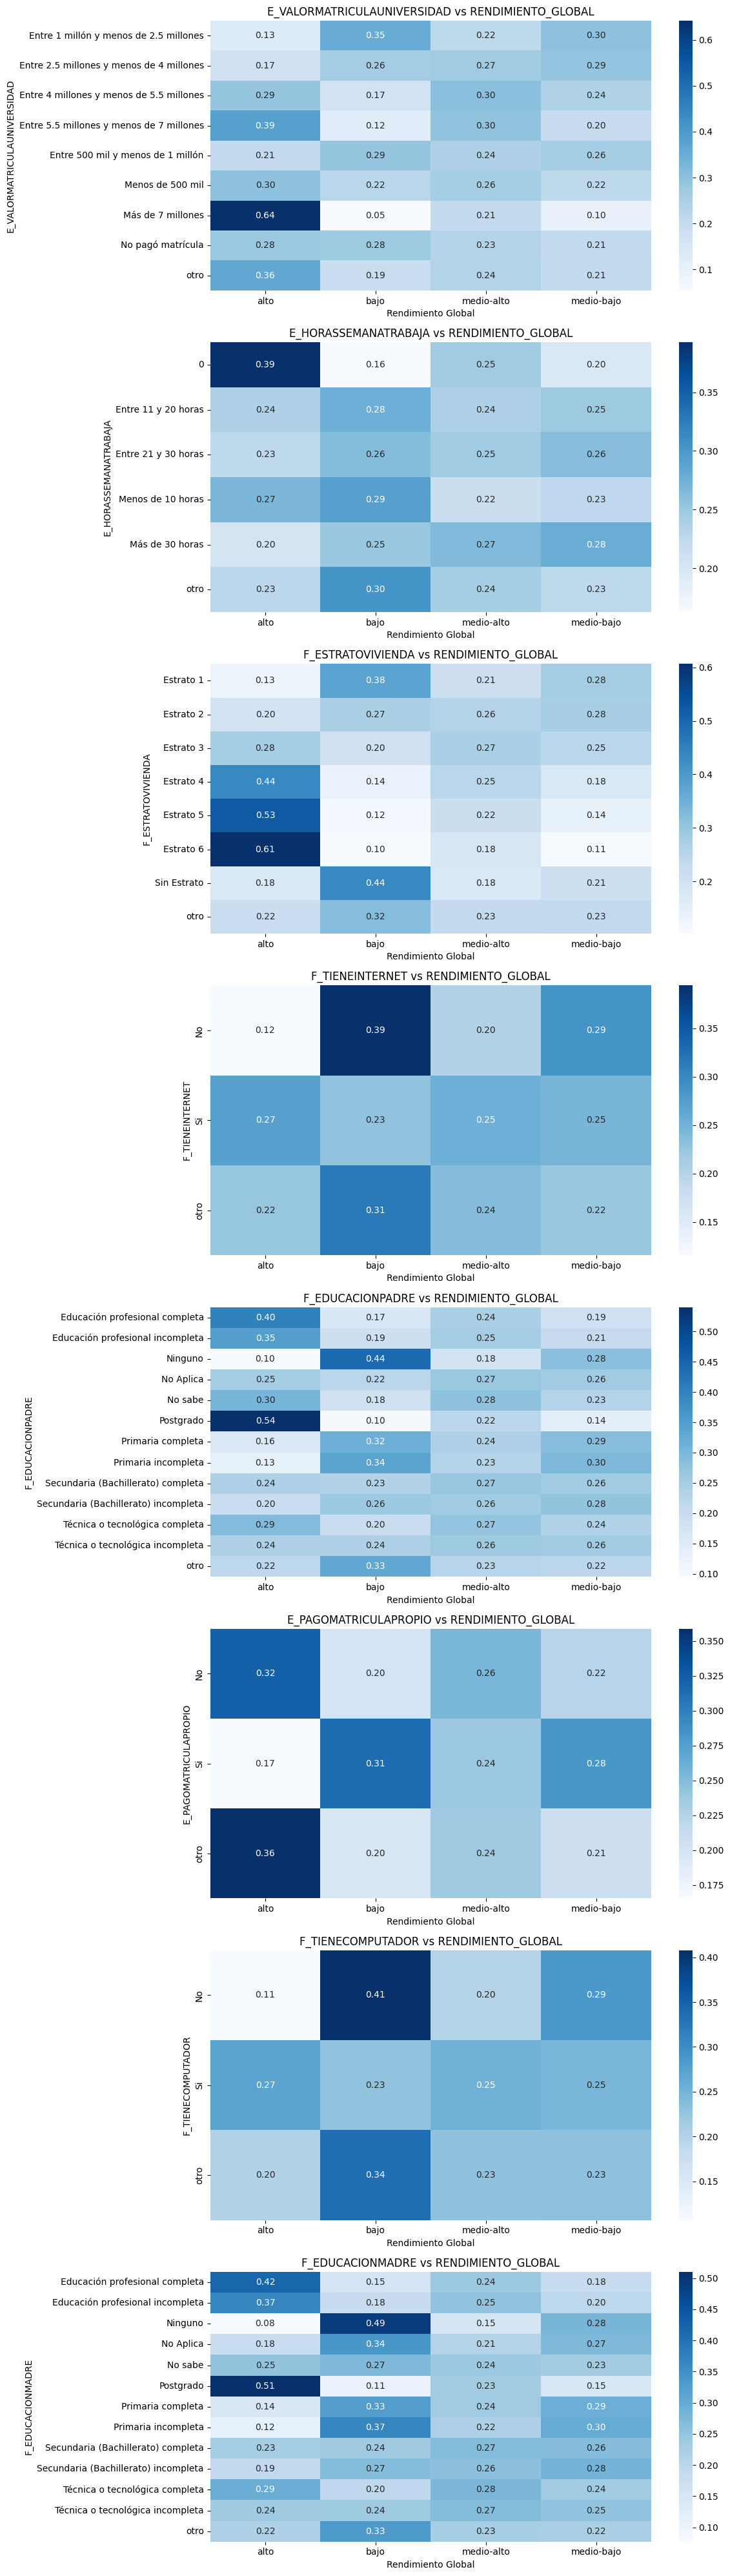

In [56]:
# Lista de variables categóricas (excluyo la variable respuesta)
variables_categoricas = [
    'E_VALORMATRICULAUNIVERSIDAD','E_HORASSEMANATRABAJA','F_ESTRATOVIVIENDA', 'F_TIENEINTERNET',
    'F_EDUCACIONPADRE','E_PAGOMATRICULAPROPIO','F_TIENECOMPUTADOR', 'F_EDUCACIONMADRE'
]

# Configuración de la figura
n = len(variables_categoricas)
cols = 1
rows = n

fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))

# Si hay una sola fila, convertir axes en lista
if rows == 1:
    axes = [axes]

for i, var in enumerate(variables_categoricas):
    ax = axes[i]

    # Tabla de proporciones
    tabla = pd.crosstab(
        df_train[var],
        df_train["RENDIMIENTO_GLOBAL"],
        normalize="index"
    )

    # Heatmap
    sns.heatmap(tabla, annot=True, cmap="Blues", fmt=".2f", ax=ax)
    ax.set_title(f"{var} vs RENDIMIENTO_GLOBAL", fontsize=12)
    ax.set_xlabel("Rendimiento Global")
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()


Con estos mapas de calor podemos ver la proporción de cada categoría de las variables en la variable respuesta. Podemos identificar algunas relaciones esperadas entre la educación de los padres, el acceso a internet o computador, el estrato de la vivienda y el rendimiento de la prueba. Aun asi, hay una proporción grande de los datos que varía, por ejemplo en los rendimientos medio-bajo, medio-alto los patrones no son muy claros, frente al valor de la matricula de la universidad las proporciones entre sus categorias son muy similares entre si con el rendimiento final de la prueba, lo que afirma la necesidad de un modelo de machine learning para captar este tipo de relaciones importantes

In [57]:
# Variables numéricas
variables = ["INDICADOR_1", "INDICADOR_2", "INDICADOR_3", "INDICADOR_4"]

# Crear figura con subplots (1 columna, 4 filas)
fig = make_subplots(
    rows=len(variables), cols=1,
    subplot_titles=[f"Promedio de {var} por RENDIMIENTO_GLOBAL" for var in variables],
    vertical_spacing=0.12
)

# Agregar gráfico de barras para cada indicador
for i, var in enumerate(variables, start=1):
    df_grouped = df_train.groupby("RENDIMIENTO_GLOBAL")[var].mean().reset_index()

    fig_bar = px.bar(
        df_grouped,
        x="RENDIMIENTO_GLOBAL",
        y=var,
        color="RENDIMIENTO_GLOBAL",
        text_auto=".2f"
    )
    for trace in fig_bar.data:
        fig.add_trace(trace, row=i, col=1)

# Ajustar diseño: barras más juntas
fig.update_traces(width=0.6)
fig.update_layout(
    bargap=0,                # espacio entre grupos de barras
    height=1600, width=1000,
    title_text="Indicadores vs RENDIMIENTO_GLOBAL (Barras de promedio)",
    showlegend=False
)

fig.show()

Por el contrario, las variables númericas (indicadores) presentan un comportamiento muy similar con el rendimiento global de la prueba, esto parece demostrar que los indicadores tienen un nulo poder predictivo frente a la variable de interes